## Download repo


In [1]:
import os
import shutil
import zipfile
import urllib.request

def download_repo(url, save_to):
    zip_filename = save_to + '.zip'
    urllib.request.urlretrieve(url, zip_filename)
    
    if os.path.exists(save_to):
        shutil.rmtree(save_to)
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall('.')
    del zip_ref
    assert os.path.exists(save_to)

In [2]:
REPO_PATH = 'LinearizedNNs-master'

download_repo(url='https://github.com/maxkvant/LinearizedNNs/archive/master.zip',
              save_to=REPO_PATH)

## Imports

In [3]:
import sys
sys.path.append(f"{REPO_PATH}/src")

In [4]:
import time
import numpy as np
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torchvision.datasets import FashionMNIST


from pytorch_impl.estimators import SgdEstimator
from pytorch_impl.nns import Myrtle5, Myrtle7, Myrtle10
from pytorch_impl import ClassifierTraining
from pytorch_impl.matrix_exp import matrix_exp, compute_exp_term
from pytorch_impl.nns.utils import to_one_hot, print_sizes
from from_neural_kernels import to_zca, CustomTensorDataset, get_cifar_zca

In [5]:
device = torch.device('cuda:0') if (torch.cuda.is_available()) else torch.device('cpu')
device

device(type='cuda', index=0)

## Cifar10

## Empirical kernel on Cifar10

In [24]:
%%time

X_train, labels_train, X_test, labels_test = get_cifar_zca()

Files already downloaded and verified
Files already downloaded and verified
CPU times: user 3min 51s, sys: 1min 2s, total: 4min 53s
Wall time: 44.1 s


In [25]:
N = 1280

X_train      = torch.tensor(X_train[:N]).float()
X_test       = torch.tensor(X_test[:N]).float()
labels_train = torch.tensor(labels_train[:N], dtype=torch.long)
labels_test  = torch.tensor(labels_test[:N],  dtype=torch.long)

num_classes = 10

y_train = to_one_hot(labels_train, num_classes).to(device)
y_test  = to_one_hot(labels_test,  num_classes).to(device)

In [8]:
def compute_kernels(models, X_train, X_test, device):
    with torch.no_grad():
        X_train = X_train.to(device)
        X_test  = X_test.to(device)

        n_train = len(X_train)
        n_test  = len(X_test)

        train_kernel = torch.zeros([n_train, n_train]).to(device)
        test_kernel  = torch.zeros([n_test,  n_train]).to(device)

        scale = np.sqrt(.5 / 0.0156249953)

        m = 0
        start_time = time.time()

        for model_i, model in enumerate(models):
            model = model.to(device)
            if model_i & (model_i - 1) == 0:
                print(f"{model_i} models done. time {time.time() - start_time:.0f}s")

            train_features = scale * model.readout(X_train) 
            test_features  = scale * model.readout(X_test)

            m += train_features.size()[1]

            train_kernel += torch.matmul(train_features, train_features.T)
            test_kernel  += torch.matmul(test_features,  train_features.T)

        train_kernel /= m
        test_kernel  /= m

        return train_kernel, test_kernel

In [32]:
torch.manual_seed(0)

n_models = 5000

# 5000 * 32 = 160k

models = [Myrtle10(num_filters=32) for _ in range(n_models)]

In [33]:
%%time

train_kernel, test_kernel = compute_kernels(models, X_train, X_test, device)

0 models done. time 0s
1 models done. time 0s
2 models done. time 0s
4 models done. time 0s
8 models done. time 0s
16 models done. time 1s
32 models done. time 1s
64 models done. time 2s
128 models done. time 5s
256 models done. time 9s
512 models done. time 19s
1024 models done. time 37s
2048 models done. time 74s
4096 models done. time 148s
CPU times: user 2min 16s, sys: 44.2 s, total: 3min
Wall time: 3min


In [34]:
train_kernel[:5,:5]

tensor([[1.0000, 0.9970, 0.9938, 0.9978, 0.9968],
        [0.9970, 1.0000, 0.9927, 0.9974, 0.9955],
        [0.9938, 0.9927, 1.0000, 0.9929, 0.9928],
        [0.9978, 0.9974, 0.9929, 1.0000, 0.9961],
        [0.9968, 0.9955, 0.9928, 0.9961, 1.0000]], device='cuda:0')

In [35]:
test_kernel[:5,:5]

tensor([[0.9969, 0.9973, 0.9938, 0.9971, 0.9953],
        [0.9955, 0.9958, 0.9908, 0.9955, 0.9964],
        [0.9958, 0.9962, 0.9956, 0.9950, 0.9943],
        [0.9960, 0.9966, 0.9941, 0.9955, 0.9951],
        [0.9974, 0.9973, 0.9920, 0.9971, 0.9954]], device='cuda:0')

In [36]:
lr = 3e4

n = len(train_kernel)
reg = torch.eye(n).to(device) * 3e-4

exp_term = - lr * compute_exp_term(- lr * (train_kernel + reg), device)
y_pred = torch.matmul(test_kernel, torch.matmul(exp_term, - y_train))
(y_pred.argmax(dim=1) == labels_test.to(device)).float().mean()

tensor(0.6125, device='cuda:0')

## Neural networks

In [14]:
%%time

X_train, y_train, X_test, y_test = get_cifar_zca()

Files already downloaded and verified
Files already downloaded and verified
CPU times: user 3min 53s, sys: 1min 4s, total: 4min 58s
Wall time: 44.8 s


In [15]:
torch.manual_seed(0)

cifar_train = CustomTensorDataset(torch.tensor(X_train), torch.tensor(y_train, dtype=torch.long), transform='all')
cifar_test  = CustomTensorDataset(torch.tensor(X_test), torch.tensor(y_test, dtype=torch.long), transform=None)

train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=128, shuffle=True)
test_loader  = torch.utils.data.DataLoader(cifar_test,  batch_size=128, shuffle=True)

device

device(type='cuda', index=0)

In [16]:
model = Myrtle10(num_filters=256).to(device)
learning_rate = 0.07

estimator = SgdEstimator(model, nn.CrossEntropyLoss(), learning_rate)
training  = ClassifierTraining(estimator, device)

# training.train(train_loader, test_loader, num_epochs=30, learning_rate=learning_rate)

In [17]:
# ClassifierTraining(estimator, device).get_accuracy(test_loader)

## Extra stats

0.051094893

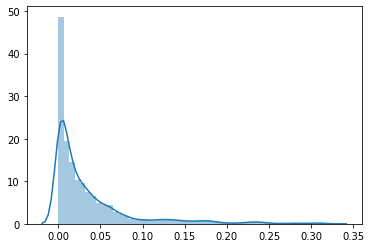

In [18]:
model = Myrtle10(num_filters=128, groups=2).to(device)
for batch_id, (X, y) in enumerate(train_loader):
    if batch_id > 20:
        break
    X, y = X.to(device), y.to(device)
    model.readout(X)

_, (X, y) = next(enumerate(train_loader))
X, y = X.to(device), y.to(device)


output = model.readout(X).detach().cpu().numpy()
sns.distplot(output.reshape(-1))

np.std(output.reshape(-1))

In [19]:
print_sizes(Myrtle10(num_filters=32).to(device))

torch.Size([32, 3, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([10, 32])
torch.Size([10])
74922


74922

In [20]:
labels_train[:10]

tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3])

In [21]:
labels_test[:10]

tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1])